In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import statsmodels.formula.api as smf
import math
import statsmodels.formula.api as sm

In [2]:
data = pd.read_csv('data.csv', sep=';')

## Data quality check / cleaning / preparation 

### Data quality check
*By Yide Cui*

The code below visualizes the distribution of all the variables in the dataset, and their association with the response.

In [3]:
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [4]:
data.y.value_counts()

no     3668
yes     451
Name: y, dtype: int64

Text(0.5, 1.0, 'Has the client subscribed a term deposit?')

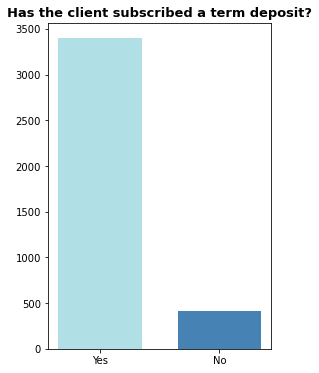

In [5]:
Subscription = {'Yes':3398, 'No':413}
YN = list(Subscription.keys())
Counts = list(Subscription.values())
  
fig = plt.figure(figsize = (4, 6))

# creating the bar plot
plt.bar(YN, Counts, color = ['powderblue', 'steelblue'], width = 0.7)
 
plt.title("Has the client subscribed a term deposit?",fontdict={'fontsize': '13', 'fontweight' : 'bold'})

### Data cleaning
*By Yide Cui*

From the data quality check we realized that:

1. Some of the columns that should have contained only numeric values, specifically <>, <>, and <> have special characters such as \*, #, %. We'll remove these characters, and convert the datatype of these columns to numeric.

2. Some of the columns have more than 60% missing values, and it is very difficult to impute their values, as the values seem to be missing at random with negligible association with other predictors. We'll remove such columns from the data.

3. The column `number_of_bedrooms` has some unreasonably high values such as 15. As our data consist of single-family homes in Evanston, we suspect that any value greater than 5 may be incorrect. We'll replace all values that are greater than 5 with an estimate obtained using the $K$-nearest neighbor approach.

4. The columns `house_price` has some unreasonably high values. We'll tag all values greater than 1 billion dollars as "potentially incorrect observation", to see if they distort our prediction / inference later on.

The code below implements the above cleaning.

In [6]:
data['education']=data['education'].replace('unknown',np.NaN)
data['marital']=data['marital'].replace('unknown',np.NaN)
data['housing']=data['housing'].replace('unknown',np.NaN)
data['loan']=data['loan'].replace('unknown',np.NaN)
data['job']=data['job'].replace('unknown',np.NaN)

data.drop(['default'], axis=1, inplace = True)
data.dropna(axis=0, inplace=True)

### Data preparation
*By Yide Cui and Angelica Wang*


In [7]:
## Binning the catogorical Data
data['education'] = data['education'].apply(lambda x:'Primary' if 'basic' in x else 'Primary' if 'illiterate' in x else 'Secondary' if 'high.school' in x else 'Secondary' if 'professional.course' in x else 'Tertiary' if 'university.degree' in x else x)
data['job'] = data['job'].apply(lambda x:'Employed' if 'admin.' in x else 'Employed' if 'blue-collar' in x else 'Employed' if 'technician' in x else 'Employed' if 'services' in x else 'Employed' if 'management' in x else 'Employed' if 'self-employed' in x else 'Employed' if 'entrepreneur' in x else 'Unemployed' if 'retired' in x else 'Unemployed' if 'unemployed' in x else 'Unemployed' if 'housemaid' in x else 'Unemployed' if 'student' in x else x)
data['marital'] = data['marital'].apply(lambda x:'single' if 'divorce' in x else x)
data['poutcome_modified'] = data['poutcome'].apply(lambda x:'failure' if 'nonexistent' in x else x)

In [8]:
data['y_dum']= data['y'].map({'no': 0, 'yes': 1})

In [9]:
data.drop(['y'], axis=1, inplace = True)

In [10]:
data['poutcome_success'] = data['poutcome'].map({'failure': 0, 'success': 1})

In [11]:
## Rename the column
data = data.rename(columns={'emp.var.rate': 'emp_var_rate', 'cons.price.idx': 'cons_price_idx', 'cons.conf.idx': 'cons_conf_idx', 'nr.employed': 'nr_employed'})

In [12]:
# Creating training and testing datasets
np.random.seed(2)
train = data.sample(round(data.shape[0]*0.8))
test = data.drop(train.index)

In [13]:
train.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,...,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,poutcome_modified,y_dum,poutcome_success
398,45,Employed,single,Tertiary,no,yes,cellular,may,fri,133,...,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1,failure,0,NaN
526,38,Employed,married,Tertiary,no,no,telephone,may,tue,477,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,failure,0,NaN
3707,60,Unemployed,married,Secondary,no,no,cellular,may,thu,181,...,1,success,-1.8,93.876,-40.0,0.699,5008.7,success,1,1.0
3687,30,Employed,single,Tertiary,no,no,cellular,sep,thu,327,...,0,nonexistent,-1.1,94.199,-37.5,0.879,4963.6,failure,1,NaN
618,31,Employed,married,Tertiary,no,no,telephone,may,wed,197,...,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,failure,0,NaN


In [14]:
test.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,...,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,poutcome_modified,y_dum,poutcome_success
6,32,Employed,single,Tertiary,yes,no,cellular,sep,mon,290,...,0,nonexistent,-1.1,94.199,-37.5,0.879,4963.6,failure,0,NaN
10,25,Employed,single,Primary,yes,no,cellular,jul,thu,301,...,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,failure,0,NaN
20,55,Employed,married,Primary,yes,no,cellular,jul,tue,326,...,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,failure,0,NaN
25,38,Employed,married,Secondary,yes,no,cellular,aug,mon,479,...,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,failure,1,NaN
26,36,Employed,single,Secondary,no,no,telephone,may,wed,446,...,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,failure,0,NaN


### Resampling Data through SMOTE
*By Yide Cui*

In [15]:
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTENC

Text(0.5, 1.0, 'Has the client subscribed a term deposit?')

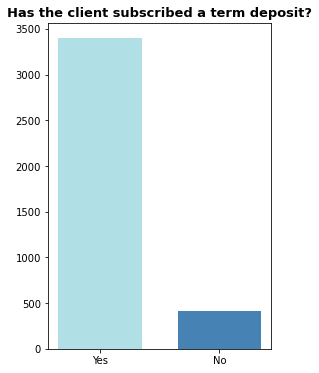

In [16]:
Subscription = {'Yes':3398, 'No':413}
YN = list(Subscription.keys())
Counts = list(Subscription.values())
  
fig = plt.figure(figsize = (4, 6))

# creating the bar plot
plt.bar(YN, Counts, color = ['powderblue', 'steelblue'], width = 0.7)
 
plt.title("Has the client subscribed a term deposit?",fontdict={'fontsize': '13', 'fontweight' : 'bold'})

In [17]:
data.drop(['poutcome_success'], axis=1, inplace = True)

In [18]:
X=data.iloc[:,:20]
y=data.iloc[:,20]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [19]:
## Balancing the train data
sm_nc = SMOTENC(categorical_features=[1,2,3,4,5,6,7,8,13,19], random_state=20)
X_train_res, y_train_res = sm_nc.fit_resample(X_train, y_train)

Y = pd.DataFrame(y_train_res, columns=["y_dum"])
train = pd.concat([X_train_res, Y], axis = 1) 
train = train.reindex(columns=["age", "job", "marital", "education", "housing", "loan", "contact", "month", 'day_of_week', "duration", "campaign", "pdays", "previous", "poutcome", "emp_var_rate", "cons_price_idx", "cons_conf_idx","euribor3m", "nr_employed", "poutcome_modified", "y_dum"])
train.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,...,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,poutcome_modified,y_dum
0,32,Unemployed,single,Tertiary,no,no,telephone,may,fri,21,...,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,failure,0
1,51,Employed,married,Secondary,yes,no,telephone,jun,mon,81,...,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,failure,0
2,31,Unemployed,single,Tertiary,yes,no,cellular,jul,tue,309,...,6,3,success,-1.7,94.215,-40.3,0.835,4991.6,success,1
3,26,Employed,married,Primary,yes,no,telephone,jun,wed,71,...,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,failure,0
4,31,Employed,single,Primary,no,no,cellular,jul,wed,1432,...,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,failure,0


## Exploratory data analysis

### Check VIF
*by Yide Cui*

In [20]:
train_dummies=pd.get_dummies(train.iloc[:,0:])

In [21]:
X = train_dummies[['age', 'duration','campaign','pdays','previous', 'euribor3m', 'cons_price_idx','cons_conf_idx', 'nr_employed','job_Employed', 'marital_married', 'education_Primary', 'housing_no', 'loan_no', 'contact_cellular', 'month_mar', 'poutcome_failure', 'day_of_week_fri']]

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["y_dum"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

                y_dum            VIF
0               const  500895.557183
1                 age       1.134226
2            duration       1.095076
3            campaign       1.078082
4               pdays       3.169159
5            previous       3.410182
6           euribor3m      54.519393
7      cons_price_idx       6.316540
8       cons_conf_idx       2.486192
9         nr_employed      43.048385
10       job_Employed       1.083310
11    marital_married       1.111546
12  education_Primary       1.128299
13         housing_no       1.038936
14            loan_no       1.039213
15   contact_cellular       1.528487
16          month_mar       1.055487
17   poutcome_failure       1.589731
18    day_of_week_fri       1.016063


In [22]:
## Deleting 'nr_employed'
X = train_dummies[['age', 'duration','campaign','pdays','previous', 'euribor3m', 'cons_price_idx','cons_conf_idx', 'job_Employed', 'marital_married', 'education_Primary', 'housing_no', 'loan_no', 'contact_cellular', 'month_mar', 'poutcome_failure', 'day_of_week_fri']]

X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["y_dum"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

                y_dum           VIF
0               const  43823.280866
1                 age      1.134193
2            duration      1.095055
3            campaign      1.067685
4               pdays      3.158839
5            previous      3.409901
6           euribor3m      2.312153
7      cons_price_idx      1.932987
8       cons_conf_idx      1.263592
9        job_Employed      1.082362
10    marital_married      1.107534
11  education_Primary      1.126969
12         housing_no      1.038088
13            loan_no      1.039197
14   contact_cellular      1.519433
15          month_mar      1.055477
16   poutcome_failure      1.587974
17    day_of_week_fri      1.013985


### Heatmap
*by Angelica Wang*

<AxesSubplot:>

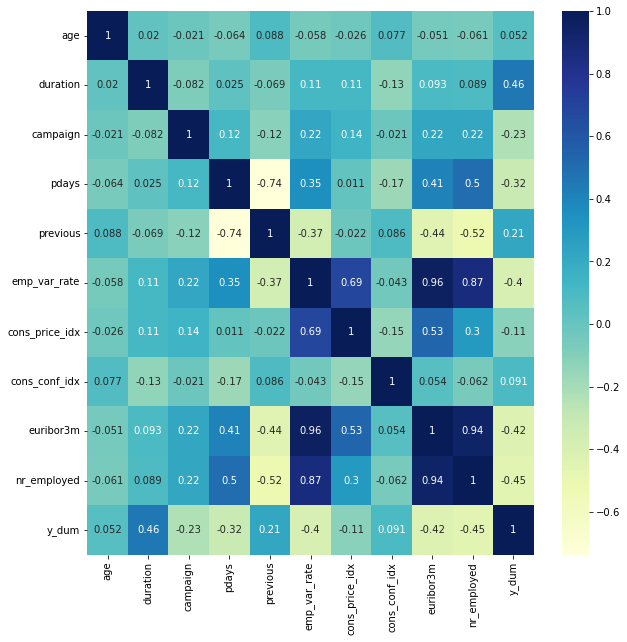

In [23]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), cmap="YlGnBu", annot=True)

### Visualizations with Individual Predictors
*By Angelica Wang*
#### Visualizations for Numerical Predictors

[Text(0.5, 0, 'euribor3m_idx'), Text(0, 0.5, 'subscription_rate')]

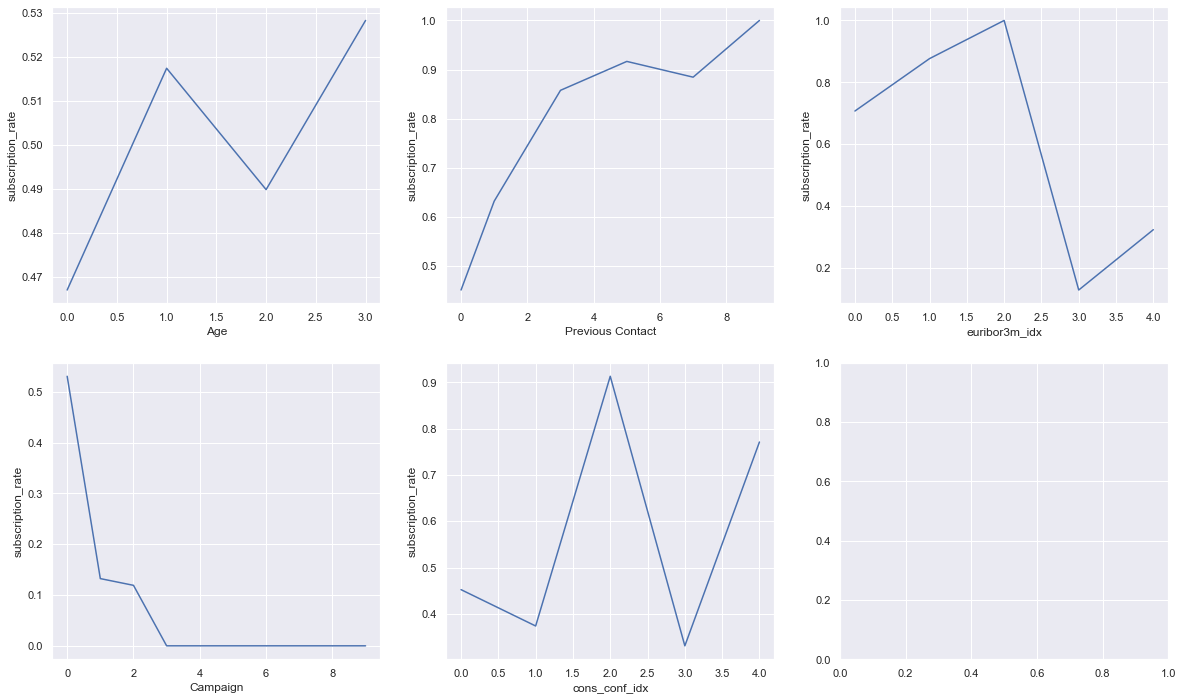

In [24]:
sns.set(rc={'figure.figsize':(20,12)})
fig, axes = plt.subplots(nrows=2, ncols=3)
#Plotting individual subplots

#Binning Age
binned_age = pd.qcut(train['age'],4,retbins=True)
train['age_binned'] = binned_age[0]
age_data = train.groupby('age_binned')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')]).reset_index(drop=False)
#Age Graph
sns.set(rc={'figure.figsize':(10,6)})
ax_age = sns.lineplot(x = age_data.index, y= age_data['subscription_rate'], ax=axes[0,0])
ax_age.set(xlabel='Age', ylabel='subscription_rate')

#Binning number of previous contacts
binned_previous = pd.cut(train['previous'],10, retbins=True, duplicates='drop')
train['previous_binned'] = binned_previous[0]
previous_data = train.groupby('previous_binned')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')]).reset_index(drop=False)
#Previous Contact Graph
sns.set(rc={'figure.figsize':(10,6)})
ax_previous = sns.lineplot(x = previous_data.index, y= previous_data['subscription_rate'], ax = axes[0,1])
ax_previous.set(xlabel='Previous Contact', ylabel='subscription_rate')


#Binning number of Campaign
binned_campaign = pd.cut(train['campaign'],10, retbins=True, duplicates='drop')
train['campaign_binned'] = binned_campaign[0]
campaign_data = train.groupby('campaign_binned')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')]).reset_index(drop=False)
#Previous Contact Graph
sns.set(rc={'figure.figsize':(10,6)})
ax_campaign = sns.lineplot(x = campaign_data.index, y= campaign_data['subscription_rate'], ax = axes[1,0])
ax_campaign.set(xlabel='Campaign', ylabel='subscription_rate')

#Binning number of Campaign
binned_cons_conf_idx = pd.cut(train['cons_conf_idx'],5, retbins=True, duplicates='drop')
train['cons_conf_idx_binned'] = binned_cons_conf_idx[0]
cons_conf_idx_data = train.groupby('cons_conf_idx_binned')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')]).reset_index(drop=False)
#Previous Contact Graph
sns.set(rc={'figure.figsize':(10,6)})
ax_cons_conf_idx = sns.lineplot(x = cons_conf_idx_data.index, y= cons_conf_idx_data['subscription_rate'], ax = axes[1,1])
ax_cons_conf_idx.set(xlabel='cons_conf_idx', ylabel='subscription_rate')

#Binning euribor 3 month rate
binned_euribor3m = pd.cut(train['euribor3m'],5, retbins=True, duplicates='drop')
train['euribor3m_binned'] = binned_euribor3m[0]
euribor3m_data = train.groupby('euribor3m_binned')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')]).reset_index(drop=False)
#Previous Contact Graph
sns.set(rc={'figure.figsize':(10,6)})
ax_euribor3m = sns.lineplot(x = euribor3m_data.index, y= euribor3m_data['subscription_rate'], ax = axes[0,2])
ax_euribor3m.set(xlabel='euribor3m_idx', ylabel='subscription_rate')



#### Visualization for Categorical Variables
*by Angelica Wang*

[Text(0.5, 0, 'housing'), Text(0, 0.5, 'subscription_rate')]

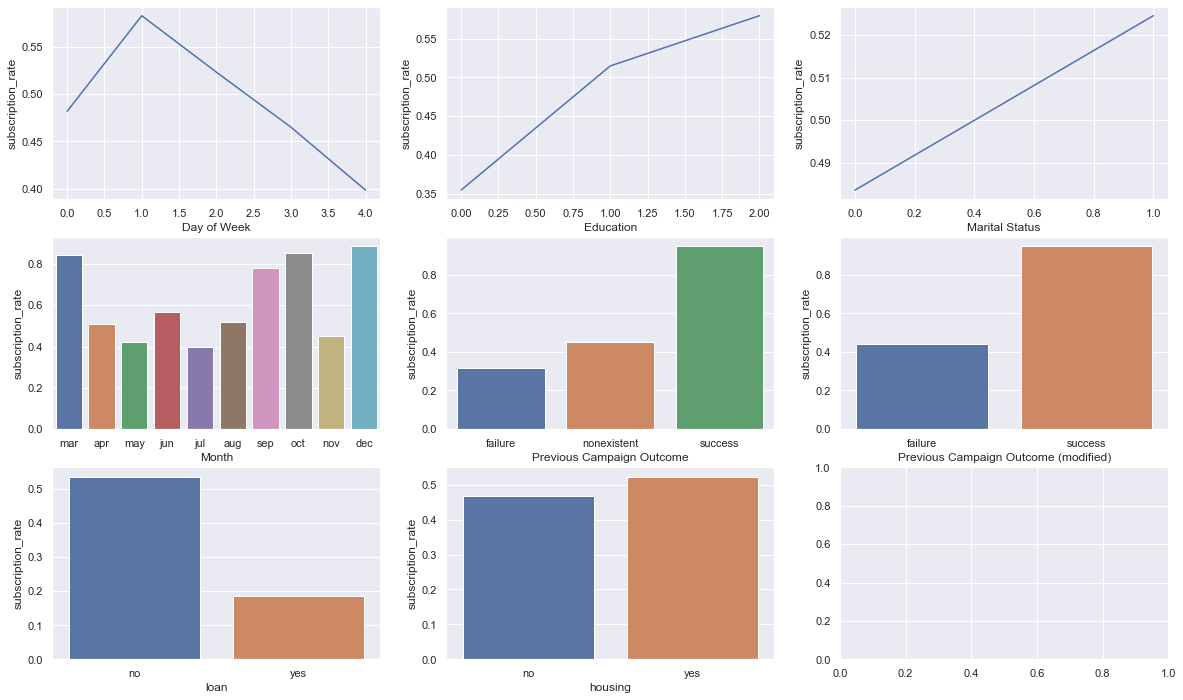

In [25]:
sns.set(rc={'figure.figsize':(20,12)})
fig, axes = plt.subplots(nrows=3, ncols=3)
#Plotting individual subplots

#Day of Week Graph
day_data = train.groupby('day_of_week')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')]).reset_index(drop=False)
ax_day = sns.lineplot(x = day_data.index, y= day_data['subscription_rate'], ax = axes[0,0])
ax_day.set(xlabel='Day of Week', ylabel='subscription_rate')

#Education Graph
edu_data = train.groupby('education')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')]).reset_index(drop=False)
ax_edu = sns.lineplot(x = edu_data.index, y= edu_data['subscription_rate'], ax = axes[0,1])
ax_edu.set(xlabel='Education', ylabel='subscription_rate')

#Marital Status Graph
marital_data = train.groupby('marital')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')]).reset_index(drop=False)
ax_marital = sns.lineplot(x = marital_data.index, y= marital_data['subscription_rate'], ax = axes[0,2])
ax_marital.set(xlabel='Marital Status', ylabel='subscription_rate')

#Month Graph
month_data = train.groupby('month')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')])
ax_month = sns.barplot(x = month_data.index, y= month_data['subscription_rate'], order = ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec'], ax = axes[1,0])
ax_month.set(xlabel='Month', ylabel='subscription_rate')

#Previous Campaign Graph
poutcome_data = train.groupby('poutcome')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')])
ax_poutcome = sns.barplot(x = poutcome_data.index, y= poutcome_data['subscription_rate'],ax = axes[1,1])
ax_poutcome.set(xlabel='Previous Campaign Outcome', ylabel='subscription_rate')

#Previous Campaign Graph with modified variable
poutcome_modified_data = train.groupby('poutcome_modified')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')])
ax_poutcome_modified = sns.barplot(x = poutcome_modified_data.index, y= poutcome_modified_data['subscription_rate'],ax = axes[1,2])
ax_poutcome_modified.set(xlabel='Previous Campaign Outcome (modified)', ylabel='subscription_rate')


#Loan Graph
loan_data = train.groupby('loan')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')])
ax_loan = sns.barplot(x = loan_data.index, y= loan_data['subscription_rate'],ax = axes[2,0])
ax_loan.set(xlabel='loan', ylabel='subscription_rate')

#Housing Graph
housing_data = train.groupby('housing')['y_dum'].agg([('subscription_rate','mean'),('nobs','count')])
ax_housing = sns.barplot(x = housing_data.index, y= housing_data['subscription_rate'],ax = axes[2,1])
ax_housing.set(xlabel='housing', ylabel='subscription_rate')

## Developing the manual model
*by Angelica Wang and Carrie Zeng*

In [26]:
from sklearn.metrics import roc_curve, auc

#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

### Interaction and Transformation Visualization
*by Carrie Zeng*

### Identify highly correlated predictors

In [38]:
train.corrwith(train.y_dum).sort_values()

nr_employed      -0.452908
euribor3m        -0.419946
emp_var_rate     -0.397602
pdays            -0.321513
campaign         -0.229041
cons_price_idx   -0.114425
age               0.052031
cons_conf_idx     0.091107
previous          0.214710
duration          0.455627
y_dum             1.000000
dtype: float64

### visualize potential correlations

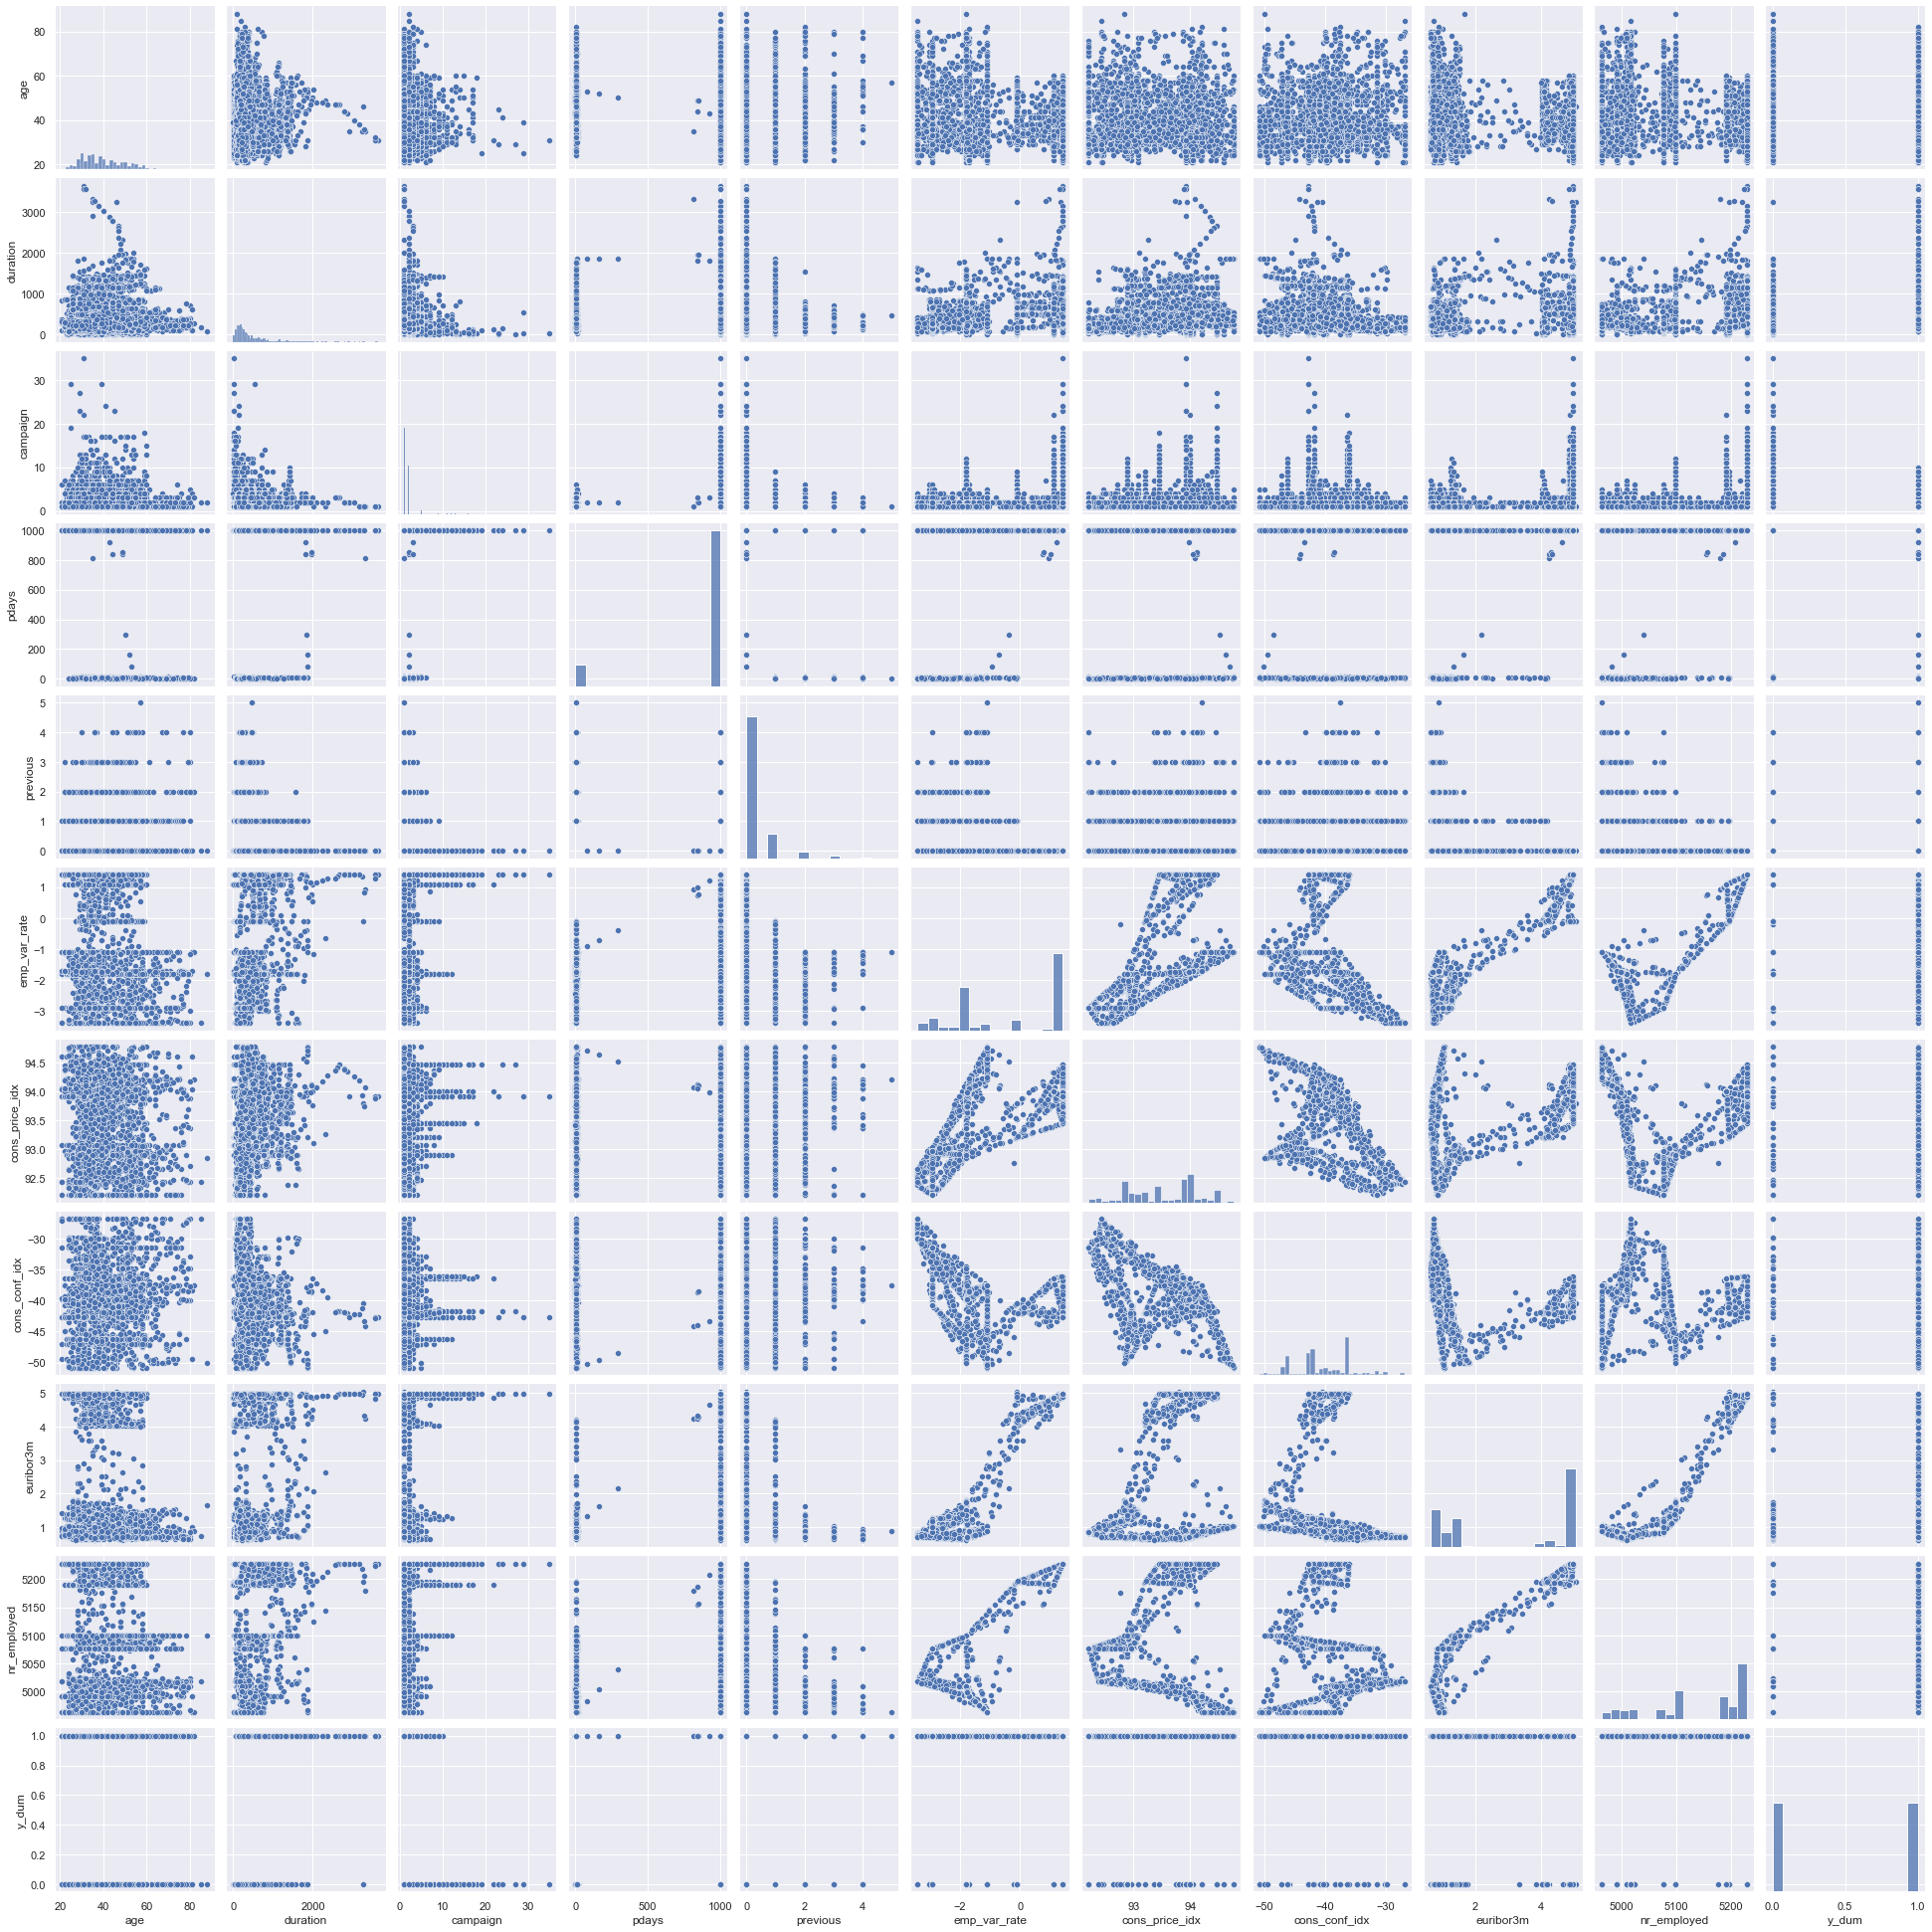

In [39]:
sns.pairplot(train)

In [27]:
model1 = smf.logit('y_dum~age', data = train).fit()
model1.summary()

Optimization terminated successfully.
         Current function value: 0.691791
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  y_dum   No. Observations:                 5450
Model:                          Logit   Df Residuals:                     5448
Method:                           MLE   Df Model:                            1
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                0.001956
Time:                        14:20:12   Log-Likelihood:                -3770.3
converged:                       True   LL-Null:                       -3777.7
Covariance Type:            nonrobust   LLR p-value:                 0.0001209
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4027      0.108     -3.714      0.000      -0.615      -0.190
age            0.0100      0.003      3.835      0.000       0.005       0.015
==============================================================================
"""

<AxesSubplot:xlabel='age', ylabel='y_dum'>

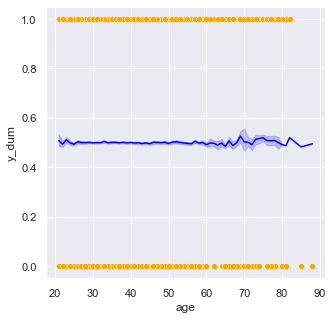

In [28]:
sns.set(rc={'figure.figsize':(5,5)})
sns.scatterplot(x = 'age', y = 'y_dum', data = train, color = 'orange') #Visualizing data
sns.lineplot(x = 'age', y= model1.predict(data), data = train, color = 'blue') #Visualizing model

Classification accuracy = 50.0%
Precision = 50.0%
TPR or Recall = 100.0%
FNR = 0.0%
FPR = 100.0%
ROC-AUC = 52.1%


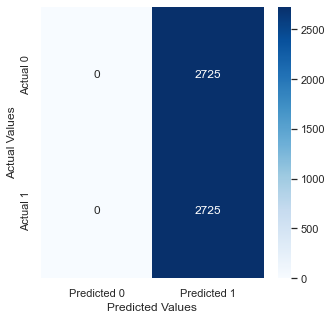

In [29]:
confusion_matrix_data(train,train.y_dum,model1,0.3)

Optimization terminated successfully.
         Current function value: 0.690819
         Iterations 5


-3764.9642325618324

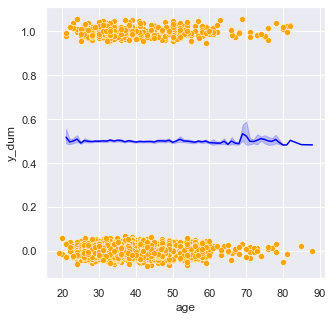

In [30]:
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x = jitter(data.age,0), y = jitter(data.y_dum,0), data = train, color = 'orange')
model1_quadra = smf.logit(formula = 'y_dum~age+I(age**2)', data = train).fit()
sns.lineplot(x = 'age', y= model1_quadra.predict(data), data = train, color = 'blue') 
model1_quadra.llf

Classification accuracy = 50.0%
Precision = 50.0%
TPR or Recall = 100.0%
FNR = 0.0%
FPR = 100.0%
ROC-AUC = 50.0%


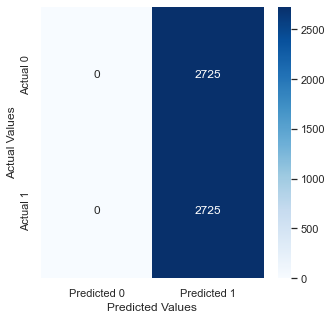

In [31]:
confusion_matrix_data(train,train.y_dum,model1_quadra,0.3)

Optimization terminated successfully.
         Current function value: 0.689737
         Iterations 6


-3759.069073559127

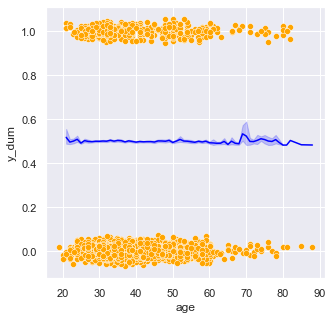

In [40]:
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x = jitter(data.age,0), y = jitter(data.y_dum,0), data = train, color = 'orange')
model1_cubic = smf.logit(formula = 'y_dum~age+I(age**2)+I(age**3)', data = train).fit()
sns.lineplot(x = 'age', y= model1_quadra.predict(data), data = train, color = 'blue') 
model1_cubic.llf

Classification accuracy = 50.0%
Precision = 50.0%
TPR or Recall = 100.0%
FNR = 0.0%
FPR = 100.0%
ROC-AUC = 50.0%


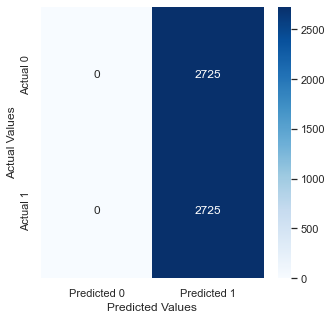

In [41]:
confusion_matrix_data(train,train.y_dum,model1_quadra,0.3)

In [42]:
model5 = smf.logit('y_dum~previous', data = train).fit()
model5.summary()

Optimization terminated successfully.
         Current function value: 0.667628
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  y_dum   No. Observations:                 5450
Model:                          Logit   Df Residuals:                     5448
Method:                           MLE   Df Model:                            1
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                 0.03682
Time:                        14:25:58   Log-Likelihood:                -3638.6
converged:                       True   LL-Null:                       -3777.7
Covariance Type:            nonrobust   LLR p-value:                 1.886e-62
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1995      0.030     -6.670      0.000      -0.258      -0.141
previous       0.8219      0.056     14.651      0.000       0.712       0.932
==============================================================================
"""

<AxesSubplot:xlabel='previous', ylabel='y_dum'>

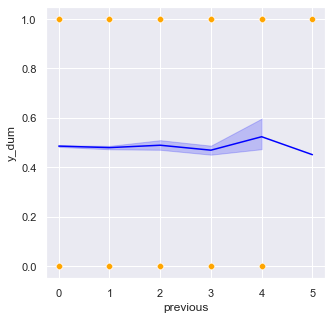

In [43]:
sns.set(rc={'figure.figsize':(5,5)})
sns.scatterplot(x = 'previous', y = 'y_dum', data = train, color = 'orange') #Visualizing data
sns.lineplot(x = 'previous', y= model5.predict(data), data = train, color = 'blue') #Visualizing model

Optimization terminated successfully.
         Current function value: 0.667626
         Iterations 6


-3638.564095479709

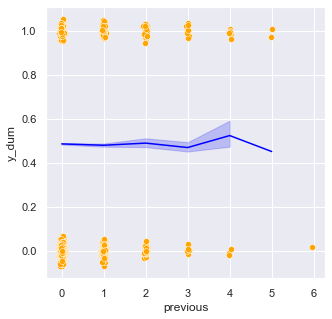

In [45]:
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x = jitter(data.previous,0), y = jitter(data.y_dum,0), data = train, color = 'orange')
model5_quadra= smf.logit(formula = 'y_dum~previous+I(previous**2)', data = train).fit()
sns.lineplot(x = 'previous', y= model5_quadra.predict(data), data = train, color = 'blue') 
model5_quadra.llf

Optimization terminated successfully.
         Current function value: 0.667148
         Iterations 6


-3635.9551001757573

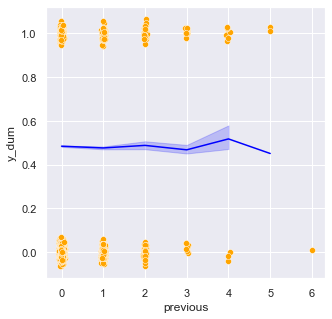

In [47]:
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x = jitter(data.previous,0), y = jitter(data.y_dum,0), data = train, color = 'orange')
model5_cubic= smf.logit(formula = 'y_dum~previous+I(previous**2)+I(previous**3)', data = train).fit()
sns.lineplot(x = 'previous', y= model5_cubic.predict(data), data = train, color = 'blue') 
model5_cubic.llf

In [48]:
model6 = smf.logit('y_dum~cons_conf_idx', data = train).fit()
model6.summary()

Optimization terminated successfully.
         Current function value: 0.688981
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  y_dum   No. Observations:                 5450
Model:                          Logit   Df Residuals:                     5448
Method:                           MLE   Df Model:                            1
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                0.006010
Time:                        14:28:32   Log-Likelihood:                -3754.9
converged:                       True   LL-Null:                       -3777.7
Covariance Type:            nonrobust   LLR p-value:                 1.597e-11
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.5208      0.229      6.651      0.000       1.073       1.969
cons_conf_idx     0.0379      0.006      6.700      0.000       0.027       0.049
=================================================================================
"""

Optimization terminated successfully.
         Current function value: 0.681031
         Iterations 7
Classification accuracy = 50.0%
Precision = 50.0%
TPR or Recall = 100.0%
FNR = 0.0%
FPR = 100.0%
ROC-AUC = 56.2%


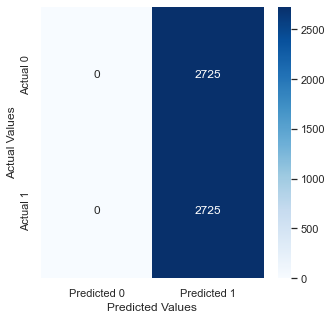

In [59]:
model6_cubic = smf.logit(formula = 'y_dum~cons_conf_idx+I(cons_conf_idx**2)+I(cons_conf_idx**3)', data = train).fit()
model6.summary()
confusion_matrix_data(train,train.y_dum,model6_cubic,0.3)

Optimization terminated successfully.
         Current function value: 0.630468
         Iterations 11
Classification accuracy = 50.0%
Precision = 50.0%
TPR or Recall = 100.0%
FNR = 0.0%
FPR = 100.0%
ROC-AUC = 60.6%


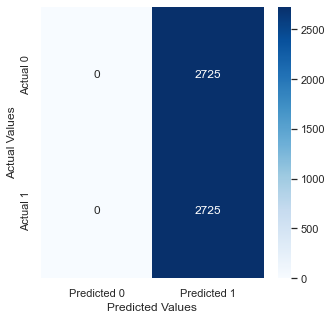

In [67]:
model7_cubic = smf.logit(formula = 'y_dum~pdays+I(pdays**2)+I(pdays**3)', data = train).fit()
confusion_matrix_data(train,train.y_dum,model7_cubic,0.3)

Optimization terminated successfully.
         Current function value: 0.632534
         Iterations 7
Classification accuracy = 50.0%
Precision = 50.0%
TPR or Recall = 100.0%
FNR = 0.0%
FPR = 100.0%
ROC-AUC = 60.6%


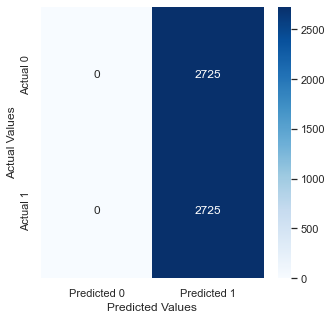

In [60]:
model7 = smf.logit(formula = 'y_dum~pdays', data = train).fit()
confusion_matrix_data(train,train.y_dum,model7,0.3)

Optimization terminated successfully.
         Current function value: 0.632260
         Iterations 7
Classification accuracy = 50.0%
Precision = 50.0%
TPR or Recall = 100.0%
FNR = 0.0%
FPR = 100.0%
ROC-AUC = 60.5%


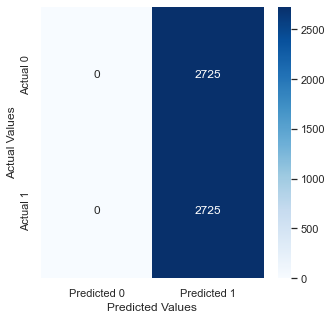

In [61]:
model7_quadra = smf.logit(formula = 'y_dum~pdays+I(pdays**2)', data = train).fit()
confusion_matrix_data(train,train.y_dum,model7_quadra,0.3)

## Interactions

In [32]:
#try interacting education, housing, and loan
model2 = sm.logit(formula = 'y_dum~age+job+marital+housing*loan+contact+month+day_of_week+campaign+pdays+previous+poutcome+euribor3m+emp_var_rate+cons_price_idx+cons_conf_idx+nr_employed', data = train).fit()
model2.summary()

Optimization terminated successfully.
         Current function value: 0.476819
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  y_dum   No. Observations:                 5450
Model:                          Logit   Df Residuals:                     5419
Method:                           MLE   Df Model:                           30
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.3121
Time:                        14:20:18   Log-Likelihood:                -2598.7
converged:                       True   LL-Null:                       -3777.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   -122.6727     34.474     -3.558      0.000    -190.240     -55.106
job[T.Unemployed]             -1.0431      0.137     -7.619      0.000      -1.311      -0.775
marital[T.single]             -0.1052      0.074     -1.426      0.154      -0.250       0.039
housing[T.yes]                 0.1947      0.074      2.645      0.008       0.050       0.339
loan[T.yes]                   -1.5693      0.223     -7.025      0.000      -2.007      -1.131
contact[T.telephone]          -1.3880      0.133    -10.455      0.000      -1.648      -1.128
month[T.aug]                   0.4661      0.203      2.293      0.022       0.068       0.865
month[T.dec]                   1.0869      0.568      1.914      0.056      -0.026       2.200
month[T.jul]                   0.2988      0.193      1.544      0.123      -0.080       0.678
month[T.jun]                   0.5790      0.192      3.017      0.003       0.203       0.955
month[T.mar]                   0.8725      0.369      2.364      0.018       0.149       1.596
month[T.may]                   0.0613      0.159      0.387      0.699      -0.250       0.372
month[T.nov]                  -0.7042      0.206     -3.427      0.001      -1.107      -0.301
month[T.oct]                   1.0515      0.291      3.614      0.000       0.481       1.622
month[T.sep]                  -0.7303      0.327     -2.231      0.026      -1.372      -0.089
day_of_week[T.mon]             0.1103      0.106      1.036      0.300      -0.098       0.319
day_of_week[T.thu]            -0.1819      0.109     -1.663      0.096      -0.396       0.032
day_of_week[T.tue]            -0.0711      0.113     -0.630      0.528      -0.292       0.150
day_of_week[T.wed]            -0.1768      0.117     -1.516      0.130      -0.405       0.052
poutcome[T.nonexistent]        1.3668      0.183      7.470      0.000       1.008       1.725
poutcome[T.success]            4.2655      0.675      6.319      0.000       2.943       5.588
housing[T.yes]:loan[T.yes]    -0.0881      0.282     -0.312      0.755      -0.641       0.464
age                            0.0081      0.004      2.227      0.026       0.001       0.015
campaign                      -0.2858      0.027    -10.774      0.000      -0.338      -0.234
pdays                          0.0009      0.001      1.270      0.204      -0.000       0.002
previous                      -0.3547      0.126     -2.808      0.005      -0.602      -0.107
euribor3m                      0.6878      0.209      3.296      0.001       0.279       1.097
emp_var_rate                  -1.2750      0.164     -7.772      0.000      -1.597      -0.953
cons_price_idx                 1.6084      0.218      7.380      0.000       1.181       2.036
cons_conf_idx                  0.0377      0.014      2.658      0.008       0.010       0.066
nr_employed                   -0.0059      0.003     -1.759      0.079      -0.012       0.001
===========

Classification accuracy = 69.5%
Precision = 64.2%
TPR or Recall = 88.2%
FNR = 11.8%
FPR = 49.1%
ROC-AUC = 84.8%


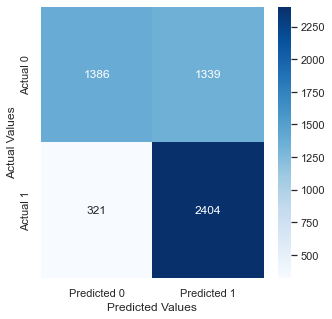

In [33]:
confusion_matrix_data(train,train.y_dum,model2,0.3)

In [34]:
#try interacting education, housing, and loan; adding campaign and poutcome
model3 = sm.logit(formula = 'y_dum~age+job+marital+education*housing*loan+contact+month+day_of_week+np.log(campaign)+campaign*poutcome+pdays+previous+I(previous**2)+euribor3m+cons_conf_idx+I(cons_conf_idx**2)+I(cons_conf_idx**3)', data = train).fit()
model3.summary()

Optimization terminated successfully.
         Current function value: 0.480476
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  y_dum   No. Observations:                 5450
Model:                          Logit   Df Residuals:                     5408
Method:                           MLE   Df Model:                           41
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.3068
Time:                        14:20:19   Log-Likelihood:                -2618.6
converged:                       True   LL-Null:                       -3777.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                           -66.1033     11.846     -5.580      0.000     -89.320     -42.886
job[T.Unemployed]                                    -0.8937      0.134     -6.661      0.000      -1.157      -0.631
marital[T.single]                                    -0.1069      0.074     -1.442      0.149      -0.252       0.038
education[T.Secondary]                                0.3144      0.140      2.253      0.024       0.041       0.588
education[T.Tertiary]                                 0.3595      0.148      2.432      0.015       0.070       0.649
housing[T.yes]                                        0.1930      0.142      1.362      0.173      -0.085       0.471
loan[T.yes]                                          -1.0967      0.348     -3.149      0.002      -1.779      -0.414
contact[T.telephone]                                 -0.6745      0.115     -5.864      0.000      -0.900      -0.449
month[T.aug]                                          0.1578      0.196      0.804      0.422      -0.227       0.543
month[T.dec]                                          1.5433      0.542      2.846      0.004       0.481       2.606
month[T.jul]                                          0.5829      0.196      2.971      0.003       0.198       0.967
month[T.jun]                                          0.8108      0.189      4.289      0.000       0.440       1.181
month[T.mar]                                          0.6248      0.376      1.663      0.096      -0.112       1.361
month[T.may]                                         -0.1545      0.162     -0.955      0.339      -0.471       0.162
month[T.nov]                                         -0.2391      0.195     -1.227      0.220      -0.621       0.143
month[T.oct]                                          2.6611      0.315      8.456      0.000       2.044       3.278
month[T.sep]                                          0.0115      0.305      0.038      0.970      -0.586       0.609
day_of_week[T.mon]                                    0.1764      0.106      1.666      0.096      -0.031       0.384
day_of_week[T.thu]                                   -0.2023      0.110     -1.838      0.066      -0.418       0.013
day_of_week[T.tue]                                   -0.0114      0.113     -0.101      0.920      -0.233       0.210
day_of_week[T.wed]                                   -0.1403      0.117     -1.200      0.230      -0.370       0.089
poutcome[T.nonexistent]                               0.9892      0.305      3.247      0.001       0.392       1.586
poutcome[T.success]                                   5.0719      0.828      6.126      0.000       3.449       6.695
education[T.Secondary]:housing[T.yes]                 0.1365      0.181      0.755      0.450      -0.218       0.491
education[T.Tertiary]:housing[T.yes]                 -0

Classification accuracy = 70.1%
Precision = 64.7%
TPR or Recall = 88.3%
FNR = 11.7%
FPR = 48.2%
ROC-AUC = 84.4%


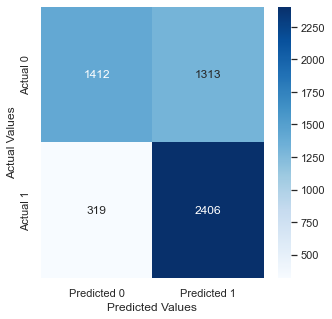

In [35]:
confusion_matrix_data(train,train.y_dum,model3,0.3)

Classification accuracy = 51.7%
Precision = 15.2%
TPR or Recall = 73.8%
FNR = 26.2%
FPR = 51.0%
ROC-AUC = 72.2%


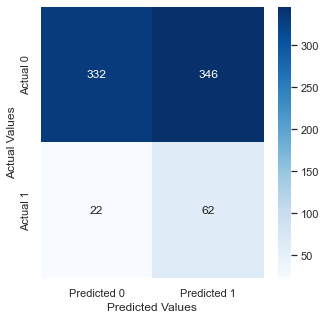

In [36]:
confusion_matrix_data(test,test.y_dum,model3,0.3)

In [84]:
#try interacting education, housing, and loan; adding pdays and poutcome
model4 = sm.logit(formula = 'y_dum~age+job+marital+education*housing*loan+contact+month+day_of_week+campaign+poutcome*pdays+previous+euribor3m+emp_var_rate+cons_price_idx+cons_conf_idx', data = train).fit()
model4.summary()

         Current function value: 0.473464
         Iterations: 35


/Users/zenghan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  y_dum   No. Observations:                 5450
Model:                          Logit   Df Residuals:                     5410
Method:                           MLE   Df Model:                           39
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.3169
Time:                        14:39:32   Log-Likelihood:                -2580.4
converged:                      False   LL-Null:                       -3777.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                          -176.7760     13.823    -12.789      0.000    -203.868    -149.684
job[T.Unemployed]                                    -1.0206      0.137     -7.467      0.000      -1.288      -0.753
marital[T.single]                                    -0.1538      0.075     -2.051      0.040      -0.301      -0.007
education[T.Secondary]                                0.2466      0.140      1.764      0.078      -0.027       0.521
education[T.Tertiary]                                 0.3270      0.147      2.225      0.026       0.039       0.615
housing[T.yes]                                        0.1630      0.143      1.143      0.253      -0.116       0.442
loan[T.yes]                                          -1.3463      0.358     -3.758      0.000      -2.048      -0.644
contact[T.telephone]                                 -1.3610      0.134    -10.175      0.000      -1.623      -1.099
month[T.aug]                                          0.4345      0.205      2.122      0.034       0.033       0.836
month[T.dec]                                          1.1781      0.578      2.037      0.042       0.045       2.311
month[T.jul]                                          0.2942      0.195      1.509      0.131      -0.088       0.676
month[T.jun]                                          0.4663      0.183      2.552      0.011       0.108       0.825
month[T.mar]                                          0.8676      0.370      2.346      0.019       0.143       1.592
month[T.may]                                          0.0593      0.160      0.370      0.711      -0.254       0.373
month[T.nov]                                         -0.6716      0.201     -3.339      0.001      -1.066      -0.277
month[T.oct]                                          1.0425      0.289      3.602      0.000       0.475       1.610
month[T.sep]                                         -0.5958      0.321     -1.856      0.063      -1.225       0.033
day_of_week[T.mon]                                    0.1176      0.107      1.099      0.272      -0.092       0.327
day_of_week[T.thu]                                   -0.1930      0.110     -1.750      0.080      -0.409       0.023
day_of_week[T.tue]                                   -0.0607      0.113     -0.535      0.593      -0.283       0.162
day_of_week[T.wed]                                   -0.1385      0.118     -1.176      0.239      -0.369       0.092
poutcome[T.nonexistent]                              59.8404   1499.773      0.040      0.968   -2879.662    2999.342
poutcome[T.success]                                   3.7440      0.733      5.106      0.000       2.307       5.181
education[T.Secondary]:housing[T.yes]                 0.1651      0.182      0.907      0.365      -0.192       0.522
education[T.Tertiary]:housing[T.yes]                 -0

Classification accuracy = 70.3%
Precision = 64.8%
TPR or Recall = 88.8%
FNR = 11.2%
FPR = 48.2%
ROC-AUC = 85.2%


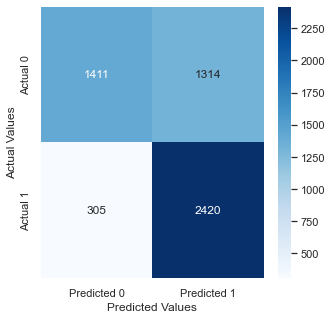

In [71]:
confusion_matrix_data(train,train.y_dum,model4,0.3)

Optimization terminated successfully.
         Current function value: 0.474992
         Iterations 8
Classification accuracy = 69.8%
Precision = 64.4%
TPR or Recall = 88.6%
FNR = 11.4%
FPR = 49.1%
ROC-AUC = 85.0%


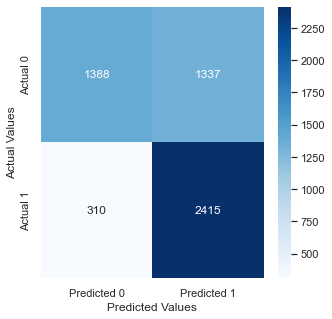

In [72]:
#interacting job and loan
model8 = sm.logit(formula = 'y_dum~age+job*loan+marital+education+housing+contact+month+day_of_week+campaign+poutcome+pdays+previous+euribor3m+emp_var_rate+cons_price_idx+cons_conf_idx+nr_employed', data = train).fit()
confusion_matrix_data(train,train.y_dum,model8,0.3)

Optimization terminated successfully.
         Current function value: 0.475392
         Iterations 8
Classification accuracy = 70.3%
Precision = 64.8%
TPR or Recall = 88.9%
FNR = 11.1%
FPR = 48.4%
ROC-AUC = 85.0%


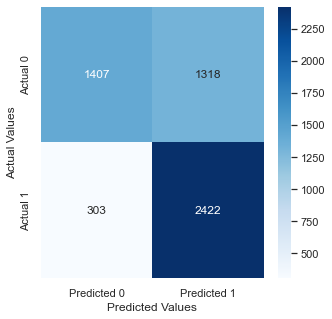

In [83]:
#interacting poutcome and loan
model9 = sm.logit(formula = 'y_dum~age+job+marital+education+housing+contact+month+day_of_week+campaign+poutcome*loan+pdays+previous+euribor3m+emp_var_rate+cons_price_idx+cons_conf_idx', data = train).fit()
confusion_matrix_data(train,train.y_dum,model9,0.3)

Optimization terminated successfully.
         Current function value: 0.473157
         Iterations 8
Classification accuracy = 70.3%
Precision = 64.8%
TPR or Recall = 89.0%
FNR = 11.0%
FPR = 48.4%
ROC-AUC = 85.2%


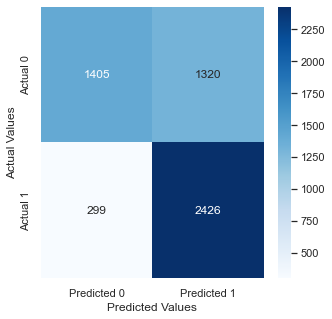

In [82]:
#integrating two interactions + interaction between marital, education and housing
model9 = sm.logit(formula = 'y_dum~age+job*loan+marital*education*housing+contact+month+day_of_week+campaign+loan*poutcome+pdays+previous+euribor3m+emp_var_rate+cons_price_idx+cons_conf_idx', data = train).fit()
confusion_matrix_data(train,train.y_dum,model9,0.3)

### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

In [88]:
logit_model = sm.logit(formula = 'y_dum~age+job*loan+marital*education*housing+month+day_of_week+np.log(campaign)+previous+I(previous**2)+poutcome_modified*loan+euribor3m+cons_conf_idx+I(cons_conf_idx**2)+I(cons_conf_idx**3)', data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.491525
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  y_dum   No. Observations:                 5450
Model:                          Logit   Df Residuals:                     5412
Method:                           MLE   Df Model:                           37
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.2909
Time:                        14:46:49   Log-Likelihood:                -2678.8
converged:                       True   LL-Null:                       -3777.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================================================
                                                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                 -58.2643     11.697     -4.981      0.000     -81.190     -35.339
job[T.Unemployed]                                          -1.0521      0.139     -7.551      0.000      -1.325      -0.779
loan[T.yes]                                                -1.5842      0.142    -11.184      0.000      -1.862      -1.307
marital[T.single]                                          -0.8149      0.259     -3.142      0.002      -1.323      -0.307
education[T.Secondary]                                      0.1665      0.158      1.052      0.293      -0.144       0.476
education[T.Tertiary]                                      -0.0108      0.174     -0.062      0.951      -0.353       0.331
housing[T.yes]                                              0.1227      0.151      0.811      0.418      -0.174       0.419
month[T.aug]                                                0.4664      0.182      2.560      0.010       0.109       0.824
month[T.dec]                                                1.3223      0.523      2.528      0.011       0.297       2.347
month[T.jul]                                                0.8932      0.186      4.804      0.000       0.529       1.258
month[T.jun]                                                0.6797      0.183      3.716      0.000       0.321       1.038
month[T.mar]                                                0.7188      0.374      1.921      0.055      -0.015       1.452
month[T.may]                                               -0.2590      0.158     -1.644      0.100      -0.568       0.050
month[T.nov]                                               -0.0521      0.189     -0.276      0.783      -0.423       0.318
month[T.oct]                                                2.6753      0.312      8.561      0.000       2.063       3.288
month[T.sep]                                                0.0041      0.299      0.014      0.989      -0.582       0.590
day_of_week[T.mon]                                          0.2105      0.105      2.011      0.044       0.005       0.416
day_of_week[T.thu]                                         -0.1923      0.109     -1.772      0.076      -0.405       0.020
day_of_week[T.tue]                                         -0.0281      0.111     -0.252      0.801      -0.246       0.190
day_of_week[T.wed]                                         -0.1982      0.116     -1.713      0.087      -0.425       0.029
poutcome_modified[T.success]                                3.4357      0.241     14.245      0.000       2.963       3.908
job[T.Unemployed]:loan[T.yes]                               0.8035      0.450      1.787      0.074      -0.078       1.685
marital[T.single]:education[T.Secondary]                    0.7720      0.307      2.516      0.012       0.171       1.373
marital[T.single]

Classification accuracy = 74.7%
Precision = 75.2%
TPR or Recall = 73.8%
FNR = 26.2%
FPR = 24.4%
ROC-AUC = 83.5%


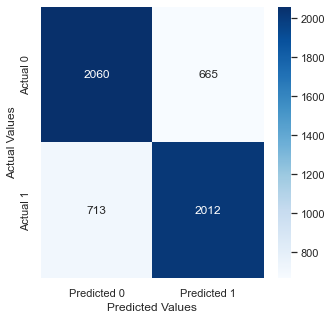

In [89]:
confusion_matrix_data(train,train.y_dum,logit_model,0.45)

Classification accuracy = 73.0%
Precision = 22.8%
TPR or Recall = 60.7%
FNR = 39.3%
FPR = 25.5%
ROC-AUC = 73.2%


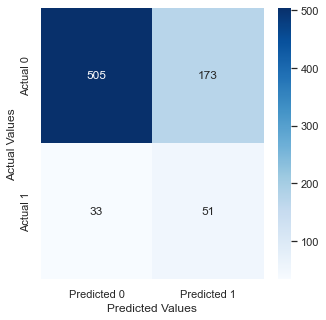

In [90]:
confusion_matrix_data(test,test.y_dum,logit_model,0.45)

## Conclusions and Recommendations to stakeholder(s)